In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import csv
import math
import json
import ast
import cv2
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', '{:.10f}'.format)

In [2]:
dtypes = {
    'v_matrix': 'str',
    'camera_name': 'str'
}

In [3]:
# path1="/data/VR_NET/folders/Venues/75_2_Venues/data_file.csv"
# df1= pd.read_csv(path1, dtype=dtypes)

# path2="/data/VR_NET/folders/Kawaii_Daycare/134_2_Kawaii_Daycare/data_file.csv"
# df2=pd.read_csv(path2, dtype=dtypes)

# path3="/data/VR_NET/folders/The_aquarium/60_1_The_aquarium/data_file.csv"
# df3= pd.read_csv(path3, dtype=dtypes)

# path4="/data/VR_NET/folders/Wake_the_Robot/72_1_Wake_the_Robot/data_file.csv"
# df4=pd.read_csv(path4, dtype=dtypes)

# path5="/data/VR_NET/folders/Wild_Quest/6_1_Wild_Quest/data_file.csv"
# df5=pd.read_csv(path5, dtype=dtypes)

# path6="/data/VR_NET/folders/Scifi_Sandbox/44_2_Scifi_Sandbox/data_file.csv"
# df6= pd.read_csv(path6, dtype=dtypes)

In [16]:
def calculate_brightness(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculate average pixel intensity
    avg_intensity = np.mean(gray_image)
    return avg_intensity

def detect_lighting_changes(images):
    # Calculate average pixel intensity for each image
    # image = image.astype('uint8')
    brightness_values = []
    for image in images:
        if image is not None:
            brightness_values.append(calculate_brightness(image.astype('uint8')))
        else:
            # Handle the case where the image is None
            brightness_values.append(0)
    brightness_changes = [abs(brightness_values[i] - brightness_values[i-1]) for i in range(1,len(brightness_values))]
    brightness_changes.insert(0, 0)
    return brightness_changes

### check later

In [4]:


dtypes = {
    'v_matrix': 'str',
    'camera_name': 'str',
    # 'object_name' : 'str',
    # 'bounds': 'str',
    # 'm_matrix': 'str'
    # define other columns as needed
}
# Selecting rows within the ratings 

# Define a function to calculate quaternion rotation change
def calculate_rotation_change(curr_quaternion, prev_quaternion):
    dot_products = np.sum(curr_quaternion * prev_quaternion, axis=1)
    angle_changes = 2 * np.arccos(np.abs(dot_products))
    return angle_changes

# Define a function to calculate magnitude change of position
def calculate_speed(curr_x, curr_y, curr_z, t1, prev_x, prev_y, prev_z, t2):
    pos_change= ((curr_x - prev_x)**2 + (curr_y - prev_y)**2 + (curr_z - prev_z)**2)**0.5
    speed= pos_change*1000/(t1-t2)
    return speed

def calculate_position_change(curr_x, curr_y, curr_z, prev_x, prev_y, prev_z):
    return ((curr_x - prev_x)**2 + (curr_y - prev_y)**2 + (curr_z - prev_z)**2)**0.5
    

def calculate_magnitude_dir(curr_x, curr_y, prev_x, prev_y):
    magnitude= ((curr_x - prev_x)**2 + (curr_y - prev_y)**2)**0.5
    dir_x= (curr_x - prev_x)/magnitude
    dir_y= (curr_y - prev_y)/magnitude
    return magnitude,dir_x, dir_y

def extract_position_and_euler_angles_from_matrix(matrix):
    matrix = np.array(matrix).reshape(4, 4).T
    # print(matrix)
    x,y,z = matrix[:3, 3]
    rotation_matrix = matrix[:3, :3]
    yaw = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    pitch = np.arcsin(-rotation_matrix[2, 0])
    roll = np.arctan2(rotation_matrix[2, 1], rotation_matrix[2, 2])

    return x,y,z, yaw, pitch, roll

def check_for_text(lst):
    ans=0
    if 'TextMeshPro' in lst:
        ans=1
    else:
        ans=0
    return ans

def calculate_brightness(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculate average pixel intensity
    avg_intensity = np.mean(gray_image)
    return avg_intensity

def detect_lighting_changes(images):
    # Calculate average pixel intensity for each image
    # image = image.astype('uint8')
    brightness_values = []
    for image in images:
        if image is not None:
            brightness_values.append(calculate_brightness(image.astype('uint8')))
        else:
            # Handle the case where the image is None
            brightness_values.append(0)
    # brightness_values = [calculate_brightness(image.astype('uint8')) for image in images]
    # Calculate differences in brightness between consecutive images
    brightness_changes = [abs(brightness_values[i] - brightness_values[i-1]) for i in range(1,len(brightness_values))]
    brightness_changes.insert(0, 0)
    # print(brightness_changes)
    # print(np.argmax(brightness_changes))
    # Define threshold for detecting major changes
    threshold = 20  # You may need to adjust this threshold based on your images
    # Check for major changes in brightness
    # major_changes = any(change > threshold for change in brightness_changes)
    return brightness_changes

# def quaternion_to_euler(list1):
#     [x,y,z,w]=list1
#     # Calculate roll
#     roll = math.atan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    
#     # Calculate pitch
#     sin_pitch = 2 * (w * y - z * x)
#     if abs(sin_pitch) >= 1:
#         pitch = math.copysign(math.pi / 2, sin_pitch)
#     else:
#         pitch = math.asin(sin_pitch)
    
#     # Calculate yaw
#     yaw = math.atan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    
#     return roll, pitch, yaw

def quaternion_to_euler(row):
    x, y, z, w = row
    # Calculate roll
    roll = math.atan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    
    # Calculate pitch
    sin_pitch = 2 * (w * y - z * x)
    if abs(sin_pitch) >= 1:
        pitch = math.copysign(math.pi / 2, sin_pitch)
    else:
        pitch = math.asin(sin_pitch)
    
    # Calculate yaw
    yaw = math.atan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    
    return pd.Series({'le_roll': roll, 'le_pitch': pitch, 'le_yaw': yaw})


def clean(df_sess_path):
    df_cleaned=[]
    df_trimmed=[]
    df_sess_path_df=os.path.join(df_sess_path,'data_file.csv')
    df_sess=pd.read_csv(df_sess_path_df, dtype=dtypes)
    df_sess_path_vid=os.path.join(df_sess_path,'video')
    # df_cleaned=[]
    # Find the index of the first and last non-null rating
    first_rating_index = df_sess['MS_rating'].first_valid_index()
    last_rating_index = df_sess['MS_rating'].last_valid_index()

    # Slice the DataFrame to retain rows only between the first and last rating
    df_trimmed = df_sess.loc[first_rating_index-1:last_rating_index]
    print("nan_count = ", df_trimmed['Buttons'].isna().sum())
    df_trimmed.reset_index(drop=True, inplace=True)

    #drop the columns without the control ratings/ fill the rating with mode of each column
    col_to_fill_mode=[ 'Buttons','IndexTrigger', 'HandTrigger','Thumbstick','left_eye','right_eye','camera_name','v_matrix','p_matrix','object_name']
    col_to_fill_median=[ 'Touches','NearTouches']
    df_cleaned=df_trimmed


    # declare the columns to be filled with mode and medians
    modes = df_cleaned[col_to_fill_mode].mode().iloc[0]
    medians = df_cleaned[col_to_fill_median].median()
    # print(modes)

    df_cleaned[col_to_fill_mode]=df_cleaned[col_to_fill_mode].fillna(modes)
    df_cleaned[col_to_fill_median]=df_cleaned[col_to_fill_median].fillna(medians)

    df_cleaned[['IndTrig_L', 'IndTrig_R']] = df_cleaned['IndexTrigger'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned[['HandTrig_L', 'HandTrig_R']] = df_cleaned['HandTrigger'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    # df_cleaned[['IndTrig_L', 'IndTrig_R','HandTrig_L', 'HandTrig_R']] = df_cleaned[['IndTrig_L', 'IndTrig_R','HandTrig_L', 'HandTrig_R']].round()

    # Apply the function to calculate magnitude for each row
    df_cleaned[['PrevX_L', 'PrevY_L', 'PrevX_R', 'PrevY_R']] = df_cleaned['Thumbstick'].apply(lambda x: pd.Series(ast.literal_eval(x)))

    # Calculate tmagnitude for left hand and right hand
    df_cleaned['Thumb_L'] = calculate_magnitude_dir(df_cleaned['PrevX_L'], df_cleaned['PrevY_L'], df_cleaned['PrevX_L'].shift(1), df_cleaned['PrevY_L'].shift(1))[0]
    df_cleaned['Thumb_R'] = calculate_magnitude_dir(df_cleaned['PrevX_R'], df_cleaned['PrevY_R'], df_cleaned['PrevX_R'].shift(1), df_cleaned['PrevY_R'].shift(1))[0]
    
    df_cleaned['Thumb_L_x'] = calculate_magnitude_dir(df_cleaned['PrevX_L'], df_cleaned['PrevY_L'], df_cleaned['PrevX_L'].shift(1), df_cleaned['PrevY_L'].shift(1))[1]
    df_cleaned['Thumb_R_x'] = calculate_magnitude_dir(df_cleaned['PrevX_R'], df_cleaned['PrevY_R'], df_cleaned['PrevX_R'].shift(1), df_cleaned['PrevY_R'].shift(1))[1]
    
    df_cleaned['Thumb_L_y'] = calculate_magnitude_dir(df_cleaned['PrevX_L'], df_cleaned['PrevY_L'], df_cleaned['PrevX_L'].shift(1), df_cleaned['PrevY_L'].shift(1))[2]
    df_cleaned['Thumb_R_y'] = calculate_magnitude_dir(df_cleaned['PrevX_R'], df_cleaned['PrevY_R'], df_cleaned['PrevX_R'].shift(1), df_cleaned['PrevY_R'].shift(1))[2]
    
    
    #Gaze

    # print("nan_count = ", df_cleaned['left_eye'].isna().sum())
    # Apply the function to extract quaternion and position components for each row
    df_cleaned[['le_x', 'le_y', 'le_z', 'le_w', 'le_p1', 'le_p2', 'le_p3']] = df_cleaned['left_eye'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    
    # df_cleaned[['le_roll', 'le_pitch', 'le_yaw']]= quaternion_to_euler(df_cleaned[['le_x', 'le_y', 'le_z', 'le_w']].values)
    df_cleaned[['le_roll', 'le_pitch', 'le_yaw']] = df_cleaned[['le_x', 'le_y', 'le_z', 'le_w']].apply(quaternion_to_euler, axis=1)

    # print(df_cleaned[['x', 'y', 'z', 'w']].values)
    # Calculate rotation change and position change
    df_cleaned['LE_speed'] = calculate_speed(df_cleaned['le_p1'], df_cleaned['le_p2'], df_cleaned['le_p3'], df_cleaned['timestamp'], df_cleaned['le_p1'].shift(1), df_cleaned['le_p2'].shift(1), df_cleaned['le_p3'].shift(1), df_cleaned['timestamp'].shift(1))
    df_cleaned['LE_pos_change']=calculate_position_change(df_cleaned['le_p1'], df_cleaned['le_p2'], df_cleaned['le_p3'], df_cleaned['le_p1'].shift(1), df_cleaned['le_p2'].shift(1), df_cleaned['le_p3'].shift(1))
    
    df_cleaned[['re_x', 're_y', 're_z', 're_w', 're_p1', 're_p2', 're_p3']] = df_cleaned['right_eye'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    # print(df_cleaned[['x', 'y', 'z', 'w']].values)
    # Calculate rotation change and position change
    df_cleaned[['re_roll', 're_pitch', 're_yaw']]= df_cleaned[['re_x', 're_y', 're_z', 're_w']].apply(quaternion_to_euler, axis=1)
    df_cleaned['RE_speed'] = calculate_speed(df_cleaned['re_p1'], df_cleaned['re_p2'], df_cleaned['re_p3'], df_cleaned['timestamp'], df_cleaned['re_p1'].shift(1), df_cleaned['re_p2'].shift(1), df_cleaned['re_p3'].shift(1), df_cleaned['timestamp'].shift(1))
    df_cleaned['RE_pos_change']=calculate_position_change(df_cleaned['re_p1'], df_cleaned['re_p2'], df_cleaned['re_p3'], df_cleaned['re_p1'].shift(1), df_cleaned['re_p2'].shift(1), df_cleaned['re_p3'].shift(1))


    #Pose: Head

    df_cleaned[['h_x', 'h_y', 'h_z', 'h_w']] = df_cleaned['head_dir'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned[['h_roll', 'h_pitch', 'h_yaw']] = df_cleaned[['h_x', 'h_y', 'h_z', 'h_w']].apply(quaternion_to_euler, axis=1)
    # df_cleaned['Head_Rot_Change'] = calculate_rotation_change(df_cleaned[['h_x', 'h_y', 'h_z', 'h_w']].values, df_cleaned[['h_x', 'h_y', 'h_z', 'h_w']].shift(1).values)

    df_cleaned[['h_p1', 'h_p2', 'h_p3']] = df_cleaned['head_pos'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned['Head_Speed'] = calculate_speed(df_cleaned['h_p1'], df_cleaned['h_p2'], df_cleaned['h_p3'],df_cleaned['timestamp'], df_cleaned['h_p1'].shift(1), df_cleaned['h_p2'].shift(1), df_cleaned['h_p3'].shift(1), df_cleaned['timestamp'].shift(1))
    df_cleaned['Head_pos_change']=calculate_position_change(df_cleaned['h_p1'], df_cleaned['h_p2'], df_cleaned['h_p3'], df_cleaned['h_p1'].shift(1), df_cleaned['h_p2'].shift(1), df_cleaned['h_p3'].shift(1))
    
    df_cleaned[['h_vp1', 'h_vp2', 'h_vp3']] = df_cleaned['head_vel'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned['Head_Velocity_Change'] = calculate_position_change(df_cleaned['h_vp1'], df_cleaned['h_vp2'], df_cleaned['h_vp3'], df_cleaned['h_vp1'].shift(1), df_cleaned['h_vp2'].shift(1), df_cleaned['h_vp3'].shift(1))

    df_cleaned[['h_avp1', 'h_avp2', 'h_avp3']] = df_cleaned['head_angvel'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned['Head_AngVel_Change'] = calculate_position_change(df_cleaned['h_avp1'], df_cleaned['h_avp2'], df_cleaned['h_avp3'], df_cleaned['h_avp1'].shift(1), df_cleaned['h_avp2'].shift(1), df_cleaned['h_avp3'].shift(1))

    
    #camera extractions
    
    df_cleaned['v_matrix'] = df_cleaned['v_matrix'].apply(ast.literal_eval)
    df_cleaned['camera_name'] = df_cleaned['camera_name'].apply(ast.literal_eval)
    df_cleaned['p_matrix'] = df_cleaned['p_matrix'].apply(ast.literal_eval)
    df_cleaned['object_name'] = df_cleaned['object_name'].apply(ast.literal_eval)


    cam_name=df_cleaned['camera_name'].to_list()
    timest=df_cleaned['timestamp'].to_list()
    v_matrix=df_cleaned['v_matrix'].to_list()
    p_matrix=df_cleaned['p_matrix'].to_list()

    c_roll=np.zeros(len(cam_name))
    c_pitch=np.zeros(len(cam_name))
    c_yaw=np.zeros(len(cam_name))
    c_x=np.zeros(len(cam_name))
    c_y=np.zeros(len(cam_name))
    c_z=np.zeros(len(cam_name))
    c_speed=np.zeros(len(cam_name))
    c_fov=np.zeros(len(cam_name))
    # c_acc_x=np.zeros()
    # c_fov_change=np.zeros(len(cam_name))

    for i in range(0,len(cam_name)):
        for y in range(len(cam_name[i])):
            # print(cam_name[i][y])
            if cam_name[i][y]=='CenterEyeAnchor':
                v_mat=v_matrix[i][y]
                # print(v_mat)
                c_x[i], c_y[i], c_z[i], c_yaw[i], c_pitch[i], c_roll[i]=extract_position_and_euler_angles_from_matrix(v_mat)
                c_fov[i]=p_matrix[i][y][0]
                
                if i!=0:
                    timediff=(timest[i]-timest[i-1])/1000
                    velocity=[(c_x[i]-c_x[i-1])/timediff, (c_y[i]-c_y[i-1])/timediff, (c_z[i]-c_z[i-1])/timediff]
                    c_speed[i]=np.linalg.norm(velocity)
                    # c_fov_change=(c_fov[i]-c_fov[i-1])*100000000

    # print(c_roll[0:5])
    df_cleaned['c_roll']=c_roll
    df_cleaned['c_pitch']=c_pitch
    df_cleaned['c_yaw']=c_yaw
    df_cleaned['c_x']=c_x
    df_cleaned['c_y']=c_y
    df_cleaned['c_z']=c_z
    df_cleaned['c_speed']=c_speed
    df_cleaned['c_fov']=c_fov
    # df_cleaned['c_fov_change']=c_fov_change
    df_cleaned['c_change_pitch']=df_cleaned['c_pitch']-df_cleaned['c_pitch'].shift(1)
    df_cleaned['c_change_roll']=df_cleaned['c_roll']-df_cleaned['c_roll'].shift(1)
    df_cleaned['c_change_yaw']=df_cleaned['c_yaw']-df_cleaned['c_yaw'].shift(1)
    # Apply the function to each row of the 'object_name' column
    df_cleaned['text_presence'] = df_cleaned['object_name'].apply(check_for_text)
    # Display the modified DataFrame
    # print(df)
    print("nan_count = ", df_cleaned['video'].isna().sum())
    # Example usage
    v_paths=df_cleaned['video'].to_list()
    # print(v_paths[0])
    ind=0
    vpaths=[]

    for i in range(len(v_paths)):
        # print(video_list[video])
        if str(v_paths[i]).startswith('vid'):
            vpaths.append( df_sess_path + str(v_paths[i]) + '.jpg')
            ind=i
        else:
            # print('yes')
            # print(i)
            vpaths.append(df_sess_path + str(v_paths[ind]) + '.jpg')
    
    images = [cv2.imread(image_path) for image_path in vpaths]
    df_cleaned['change in brightness']=detect_lighting_changes(images)
    
    
    df_cleaned['diff_HE_yaw'] = df_cleaned['le_yaw'] - df_cleaned['h_yaw']
    df_cleaned['diff_HE_roll'] = df_cleaned['le_roll'] - df_cleaned['h_roll']
    df_cleaned['diff_HE_pitch'] = df_cleaned['le_pitch'] - df_cleaned['h_pitch']
    

    df_cleaned.reset_index(drop=True, inplace=True)
    # df_final=df_cleaned[['Buttons', 'Touches', 'NearTouches','IndTrig_L', 'IndTrig_R','HandTrig_L', 'HandTrig_R','Thumb_L','Thumb_R',
    #                      'LEye_Rot_Change','LEye_Position_Change','REye_Rot_Change','REye_Position_Change','Head_Position_Change',
    #                      'Head_Rot_Change','Head_Velocity_Change', 'Head_AngVel_Change','Camera_rot']]
    print("nan_count = ", df_cleaned['Buttons'].isna().sum())
    return df_cleaned

In [17]:
def clean(df_sess_path):
    df_cleaned=[]
    df_trimmed=[]
    df_sess_path_df=os.path.join(df_sess_path,'data_file.csv')
    df_sess=pd.read_csv(df_sess_path_df, dtype=dtypes)
    df_sess_path_vid=os.path.join(df_sess_path,'video')
    # df_cleaned=[]
    # Find the index of the first and last non-null rating
    first_rating_index = df_sess['MS_rating'].first_valid_index()
    last_rating_index = df_sess['MS_rating'].last_valid_index()

    # Slice the DataFrame to retain rows only between the first and last rating
    df_trimmed = df_sess.loc[first_rating_index-1:last_rating_index]
    # print("nan_count = ", df_trimmed['Buttons'].isna().sum())
    df_trimmed.reset_index(drop=True, inplace=True)

    #drop the columns without the control ratings/ fill the rating with mode of each column
    col_to_fill_mode=[ 'Buttons','IndexTrigger', 'HandTrigger','Thumbstick','left_eye','right_eye','camera_name','v_matrix','p_matrix','object_name']
    col_to_fill_median=[ 'Touches','NearTouches']
    df_cleaned=df_trimmed


    # declare the columns to be filled with mode and medians
    modes = df_cleaned[col_to_fill_mode].mode().iloc[0]
    medians = df_cleaned[col_to_fill_median].median()
    # print(modes)

    df_cleaned[col_to_fill_mode]=df_cleaned[col_to_fill_mode].fillna(modes)
    df_cleaned[col_to_fill_median]=df_cleaned[col_to_fill_median].fillna(medians)

    df_cleaned[['IndTrig_L', 'IndTrig_R']] = df_cleaned['IndexTrigger'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned[['HandTrig_L', 'HandTrig_R']] = df_cleaned['HandTrigger'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    # df_cleaned[['IndTrig_L', 'IndTrig_R','HandTrig_L', 'HandTrig_R']] = df_cleaned[['IndTrig_L', 'IndTrig_R','HandTrig_L', 'HandTrig_R']].round()

    # Apply the function to calculate magnitude for each row
    df_cleaned[['PrevX_L', 'PrevY_L', 'PrevX_R', 'PrevY_R']] = df_cleaned['Thumbstick'].apply(lambda x: pd.Series(ast.literal_eval(x)))

    # Calculate tmagnitude for left hand and right hand
    df_cleaned['Thumb_L'] = calculate_magnitude_dir(df_cleaned['PrevX_L'], df_cleaned['PrevY_L'], df_cleaned['PrevX_L'].shift(1), df_cleaned['PrevY_L'].shift(1))[0]
    df_cleaned['Thumb_R'] = calculate_magnitude_dir(df_cleaned['PrevX_R'], df_cleaned['PrevY_R'], df_cleaned['PrevX_R'].shift(1), df_cleaned['PrevY_R'].shift(1))[0]
    
    df_cleaned['Thumb_L_x'] = calculate_magnitude_dir(df_cleaned['PrevX_L'], df_cleaned['PrevY_L'], df_cleaned['PrevX_L'].shift(1), df_cleaned['PrevY_L'].shift(1))[1]
    df_cleaned['Thumb_R_x'] = calculate_magnitude_dir(df_cleaned['PrevX_R'], df_cleaned['PrevY_R'], df_cleaned['PrevX_R'].shift(1), df_cleaned['PrevY_R'].shift(1))[1]
    
    df_cleaned['Thumb_L_y'] = calculate_magnitude_dir(df_cleaned['PrevX_L'], df_cleaned['PrevY_L'], df_cleaned['PrevX_L'].shift(1), df_cleaned['PrevY_L'].shift(1))[2]
    df_cleaned['Thumb_R_y'] = calculate_magnitude_dir(df_cleaned['PrevX_R'], df_cleaned['PrevY_R'], df_cleaned['PrevX_R'].shift(1), df_cleaned['PrevY_R'].shift(1))[2]
    
    
    #Gaze

    # print("nan_count = ", df_cleaned['left_eye'].isna().sum())
    # Apply the function to extract quaternion and position components for each row
    df_cleaned[['le_x', 'le_y', 'le_z', 'le_w', 'le_p1', 'le_p2', 'le_p3']] = df_cleaned['left_eye'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    
    # df_cleaned[['le_roll', 'le_pitch', 'le_yaw']]= quaternion_to_euler(df_cleaned[['le_x', 'le_y', 'le_z', 'le_w']].values)
    df_cleaned[['le_roll', 'le_pitch', 'le_yaw']] = df_cleaned[['le_x', 'le_y', 'le_z', 'le_w']].apply(quaternion_to_euler, axis=1)

    # print(df_cleaned[['x', 'y', 'z', 'w']].values)
    # Calculate rotation change and position change
    df_cleaned['LE_speed'] = calculate_speed(df_cleaned['le_p1'], df_cleaned['le_p2'], df_cleaned['le_p3'], df_cleaned['timestamp'], df_cleaned['le_p1'].shift(1), df_cleaned['le_p2'].shift(1), df_cleaned['le_p3'].shift(1), df_cleaned['timestamp'].shift(1))
    df_cleaned['LE_pos_change']=calculate_position_change(df_cleaned['le_p1'], df_cleaned['le_p2'], df_cleaned['le_p3'], df_cleaned['le_p1'].shift(1), df_cleaned['le_p2'].shift(1), df_cleaned['le_p3'].shift(1))
    
    df_cleaned[['re_x', 're_y', 're_z', 're_w', 're_p1', 're_p2', 're_p3']] = df_cleaned['right_eye'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    # print(df_cleaned[['x', 'y', 'z', 'w']].values)
    # Calculate rotation change and position change
    df_cleaned[['re_roll', 're_pitch', 're_yaw']]= df_cleaned[['re_x', 're_y', 're_z', 're_w']].apply(quaternion_to_euler, axis=1)
    df_cleaned['RE_speed'] = calculate_speed(df_cleaned['re_p1'], df_cleaned['re_p2'], df_cleaned['re_p3'], df_cleaned['timestamp'], df_cleaned['re_p1'].shift(1), df_cleaned['re_p2'].shift(1), df_cleaned['re_p3'].shift(1), df_cleaned['timestamp'].shift(1))
    df_cleaned['RE_pos_change']=calculate_position_change(df_cleaned['re_p1'], df_cleaned['re_p2'], df_cleaned['re_p3'], df_cleaned['re_p1'].shift(1), df_cleaned['re_p2'].shift(1), df_cleaned['re_p3'].shift(1))


    #Pose: Head

    df_cleaned[['h_x', 'h_y', 'h_z', 'h_w']] = df_cleaned['head_dir'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned[['h_roll', 'h_pitch', 'h_yaw']] = df_cleaned[['h_x', 'h_y', 'h_z', 'h_w']].apply(quaternion_to_euler, axis=1)
    # df_cleaned['Head_Rot_Change'] = calculate_rotation_change(df_cleaned[['h_x', 'h_y', 'h_z', 'h_w']].values, df_cleaned[['h_x', 'h_y', 'h_z', 'h_w']].shift(1).values)

    df_cleaned[['h_p1', 'h_p2', 'h_p3']] = df_cleaned['head_pos'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned['Head_Speed'] = calculate_speed(df_cleaned['h_p1'], df_cleaned['h_p2'], df_cleaned['h_p3'],df_cleaned['timestamp'], df_cleaned['h_p1'].shift(1), df_cleaned['h_p2'].shift(1), df_cleaned['h_p3'].shift(1), df_cleaned['timestamp'].shift(1))
    df_cleaned['Head_pos_change']=calculate_position_change(df_cleaned['h_p1'], df_cleaned['h_p2'], df_cleaned['h_p3'], df_cleaned['h_p1'].shift(1), df_cleaned['h_p2'].shift(1), df_cleaned['h_p3'].shift(1))
    
    df_cleaned[['h_vp1', 'h_vp2', 'h_vp3']] = df_cleaned['head_vel'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned['Head_Velocity_Change'] = calculate_position_change(df_cleaned['h_vp1'], df_cleaned['h_vp2'], df_cleaned['h_vp3'], df_cleaned['h_vp1'].shift(1), df_cleaned['h_vp2'].shift(1), df_cleaned['h_vp3'].shift(1))

    df_cleaned[['h_avp1', 'h_avp2', 'h_avp3']] = df_cleaned['head_angvel'].apply(lambda x: pd.Series(ast.literal_eval(x)))
    df_cleaned['Head_AngVel_Change'] = calculate_position_change(df_cleaned['h_avp1'], df_cleaned['h_avp2'], df_cleaned['h_avp3'], df_cleaned['h_avp1'].shift(1), df_cleaned['h_avp2'].shift(1), df_cleaned['h_avp3'].shift(1))

    
    #camera extractions
    
    df_cleaned['v_matrix'] = df_cleaned['v_matrix'].apply(ast.literal_eval)
    df_cleaned['camera_name'] = df_cleaned['camera_name'].apply(ast.literal_eval)
    df_cleaned['p_matrix'] = df_cleaned['p_matrix'].apply(ast.literal_eval)
    df_cleaned['object_name'] = df_cleaned['object_name'].apply(ast.literal_eval)


    cam_name=df_cleaned['camera_name'].to_list()
    timest=df_cleaned['timestamp'].to_list()
    v_matrix=df_cleaned['v_matrix'].to_list()
    p_matrix=df_cleaned['p_matrix'].to_list()

    c_roll=np.zeros(len(cam_name))
    c_pitch=np.zeros(len(cam_name))
    c_yaw=np.zeros(len(cam_name))
    c_x=np.zeros(len(cam_name))
    c_y=np.zeros(len(cam_name))
    c_z=np.zeros(len(cam_name))
    c_speed=np.zeros(len(cam_name))
    c_fov=np.zeros(len(cam_name))
    # c_fov_change=np.zeros(len(cam_name))

    for i in range(0,len(cam_name)):
        for y in range(len(cam_name[i])):
            # print(cam_name[i][y])
            if cam_name[i][y]=='CenterEyeAnchor':
                v_mat=v_matrix[i][y]
                # print(v_mat)
                c_x[i], c_y[i], c_z[i], c_yaw[i], c_pitch[i], c_roll[i]=extract_position_and_euler_angles_from_matrix(v_mat)
                c_fov[i]=p_matrix[i][y][0]
                
                if i!=0:
                    timediff=(timest[i]-timest[i-1])/1000
                    velocity=[(c_x[i]-c_x[i-1])/timediff, (c_y[i]-c_y[i-1])/timediff, (c_z[i]-c_z[i-1])/timediff]
                    c_speed[i]=np.linalg.norm(velocity)
                    # c_fov_change=(c_fov[i]-c_fov[i-1])*100000000

    # print(c_roll[0:5])
    df_cleaned['c_roll']=c_roll
    df_cleaned['c_pitch']=c_pitch
    df_cleaned['c_yaw']=c_yaw
    df_cleaned['c_x']=c_x
    df_cleaned['c_y']=c_y
    df_cleaned['c_z']=c_z
    df_cleaned['c_speed']=c_speed
    df_cleaned['c_fov']=c_fov
    # df_cleaned['c_fov_change']=c_fov_change
    df_cleaned['c_change_pitch']=abs(df_cleaned['c_pitch']-df_cleaned['c_pitch'].shift(1))
    df_cleaned['c_change_roll']=abs(df_cleaned['c_roll']-df_cleaned['c_roll'].shift(1))
    df_cleaned['c_change_yaw']=abs(df_cleaned['c_yaw']-df_cleaned['c_yaw'].shift(1))
    # Apply the function to each row of the 'object_name' column
    df_cleaned['text_presence'] = df_cleaned['object_name'].apply(check_for_text)
    # Display the modified DataFrame
    # print(df)
    # print("nan_count = ", df_cleaned['video'].isna().sum())
    # Example usage
    v_paths=df_cleaned['video'].to_list()
    # print(vpaths[0])
    vpaths=[]
    ind=0

    for i in range(len(v_paths)):
        # print(video_list[video])
        if str(v_paths[i]).startswith('vid'):
            vpaths.append( os.path.join(df_sess_path,str(v_paths[i]) + '.jpg'))
            ind=i
        else:
            # print('yes')
            # print(i)
            vpaths.append(os.path.join(df_sess_path,str(v_paths[ind]) + '.jpg'))
    # print(vpaths)
    
    images = [cv2.imread(image_path) for image_path in vpaths]
    df_cleaned['change in brightness']=detect_lighting_changes(images)
    # print(images)
    
    df_cleaned['diff_HE_yaw'] = abs(df_cleaned['le_yaw'] - df_cleaned['h_yaw'])
    df_cleaned['diff_HE_roll'] = abs(df_cleaned['le_roll'] - df_cleaned['h_roll'])
    df_cleaned['diff_HE_pitch'] = abs(df_cleaned['le_pitch'] - df_cleaned['h_pitch'])
    
    df_cleaned['hour'] = pd.to_datetime(df_cleaned['timestamp'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai').dt.hour
    
    df_cleaned.reset_index(drop=True, inplace=True)
    
    df_final=df_cleaned[['frame', 'hour','Buttons', 'IndTrig_L', 'IndTrig_R', 'HandTrig_L',
       'HandTrig_R', 'Thumb_L', 'Thumb_R', 'Thumb_L_x', 'Thumb_R_x', 'Thumb_L_y', 'Thumb_R_y', 
       'LE_speed', 'LE_pos_change','Head_Speed', 'Head_pos_change', 'Head_Velocity_Change', 'Head_AngVel_Change', 
       'c_speed',  'text_presence', 'change in brightness','diff_HE_yaw', 'diff_HE_roll', 'diff_HE_pitch' , 
       'c_change_pitch', 'c_change_roll', 'c_change_yaw', 'MS_rating']]
    
    return df_final

In [18]:
df_fin1=clean('/data/VR_NET/folders/Venues/75_2_Venues/')
# df_fin2=clean('/data/VR_NET/folders/Kawaii_Daycare/134_2_Kawaii_Daycare')
df_fin2=clean('/data/VR_NET/folders/The_aquarium/60_1_The_aquarium')
# df_fin4=clean('/data/VR_NET/folders/Wake_the_Robot/72_1_Wake_the_Robot/')
df_fin3=clean('/data/VR_NET/folders/Kawaii_Daycare/130_2_Kawaii_Daycare')
df_fin4=clean('/data/VR_NET/folders/Wild_Quest/7_2_Wild_Quest')

### MS_Rating

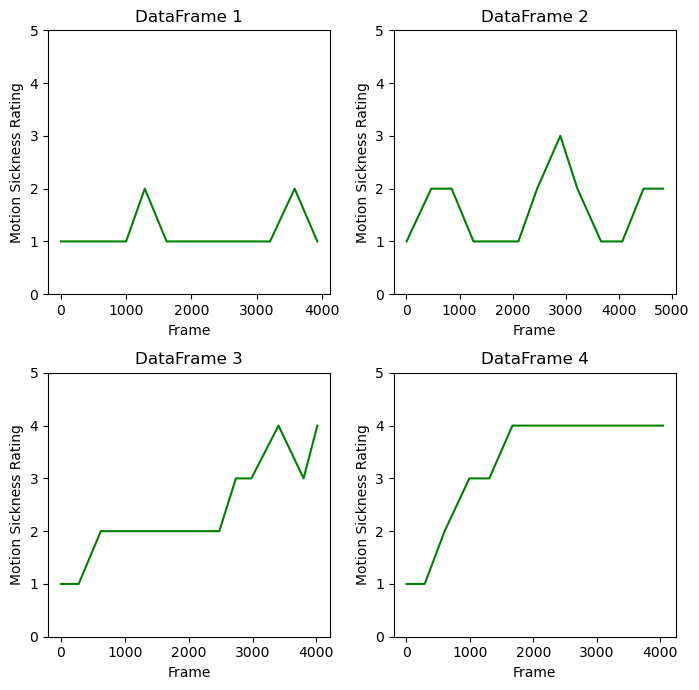

In [49]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

# Iterate over DataFrames and plot NearTouches
for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
    # df['c_roll'].plot(ax=axes[i])
    df_filtered = df.dropna(subset=['MS_rating'])
    df_filtered['MS_rating'].plot(ax=axes[i], color='green')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Motion Sickness Rating')
    axes[i].set_ylim(0, 5)

plt.tight_layout()
plt.show()

### Control

#### Buttons

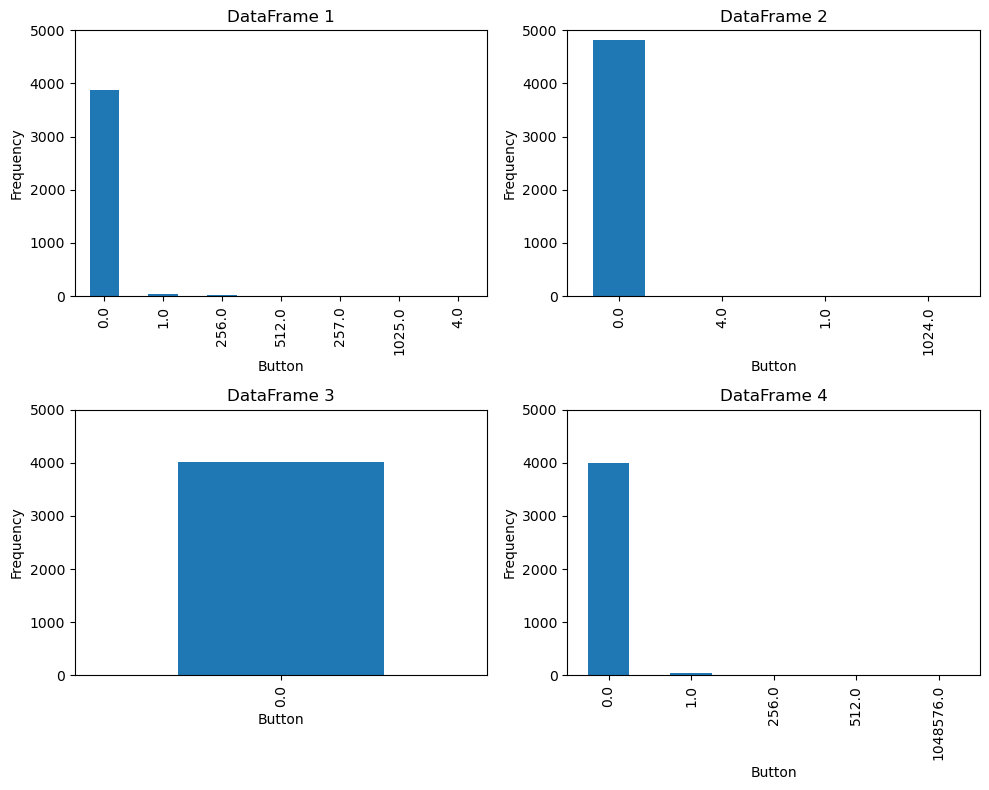

In [15]:
dfc=df_fin1

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(10,8))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
    value_counts = df['Buttons'].value_counts()
    value_counts.plot(kind='bar', ax=axes[i])
    
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Button')
    axes[i].set_ylabel('Frequency')
    axes[i].set_ylim(0, 5000)

plt.tight_layout()
plt.show()


In [19]:
dfc=df_fin1

# # Plotting
# fig, axes = plt.subplots(2, 2, figsize=(10,8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()
# def count_ones_in_binary(x):
#     return bin(int(x)).count('1')

# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # value_counts = df['Buttons'].value_counts()
    

# # Apply the function to the 'Buttons' column
#     df['Ones Count'] = df['Buttons'].apply(count_ones_in_binary)
#     df['Ones Count'].plot(ax=axes[i], color='green')
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     print(max(df['Ones Count']))
#     # for index, value in enumerate(value_counts):
#     #     axes[i].text(index, value, str(value), ha='center', va='bottom')
    
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Number of Buttons Pressed')
#     axes[i].set_ylim(0,5)

# plt.tight_layout()
# plt.show()

In [8]:
df_fin1["Touches"]

0      5140.0000000000
1      5140.0000000000
2      5140.0000000000
3      5140.0000000000
4      5140.0000000000
             ...      
3928   4116.0000000000
3929   4116.0000000000
3930   5140.0000000000
3931   4116.0000000000
3932   5140.0000000000
Name: Touches, Length: 3933, dtype: float64

In [ ]:

# # # Plotting
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     value_counts = df['Touches'].value_counts()
#     value_counts.plot(kind='bar', ax=axes[i])
    
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Button')
#     axes[i].set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # value_counts = df['Touches'].value_counts()
#     # value_counts.plot(kind='bar', ax=axes[i])
#     df['Ones Count'] = df['Touches'].apply(count_ones_in_binary)
#     df['Ones Count'].plot(ax=axes[i], color='green')
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Button')
#     axes[i].set_ylabel('Frequency')
#     axes[i].set_ylim(0,6)

# plt.tight_layout()
# plt.show()

#### Index Trigger

In [11]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     df['IndTrig_L'].plot(ax=axes[i])
#     # df_filtered = df.dropna(subset=['MS_rating'])
#     # df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('IndexTrigger Left')
#     axes[i].set_ylim(0,5)

# plt.tight_layout()
# plt.show()

In [12]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     df['IndTrig_R'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('IndexTrigger Right')
#     axes[i].set_ylim(0,5)

# plt.tight_layout()
# plt.show()

#### Hand Trigger

In [20]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     df['HandTrig_L'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('HandTrigger Left')
#     axes[i].set_ylim(0,5)

# plt.tight_layout()
# plt.show()

In [21]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     df['HandTrig_R'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('HandTrigger Right')
#     axes[i].set_ylim(0,5)

# plt.tight_layout()
# plt.show()

In [60]:
df_fin1.columns[50:90]

Index(['Thumb_R', 'Thumb_L_x', 'Thumb_R_x', 'Thumb_L_y', 'Thumb_R_y', 'le_x',
       'le_y', 'le_z', 'le_w', 'le_p1', 'le_p2', 'le_p3', 'le_roll',
       'le_pitch', 'le_yaw', 'LE_speed', 'LE_pos_change', 're_x', 're_y',
       're_z', 're_w', 're_p1', 're_p2', 're_p3', 're_roll', 're_pitch',
       're_yaw', 'RE_speed', 'RE_pos_change', 'h_x', 'h_y', 'h_z', 'h_w',
       'h_roll', 'h_pitch', 'h_yaw', 'h_p1', 'h_p2', 'h_p3', 'Head_Speed'],
      dtype='object')

In [28]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     df['PrevX_L'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick X Left')
#     axes[i].set_ylim(-1.5,5)

# plt.tight_layout()
# plt.show()

In [29]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     df['PrevY_L'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Y Left')
#     axes[i].set_ylim(-1.5,5)
#     # axes[i].set_ylim(0,5)

# plt.tight_layout()
# plt.show()

In [35]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     df['PrevX_R'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick X Right')
#     axes[i].set_ylim(-1.5,5)

# plt.tight_layout()
# plt.show()

In [36]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     df['PrevY_R'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Y Right')
#     axes[i].set_ylim(-1.5,5)
#     # axes[i].set_ylim(0,5)

# plt.tight_layout()
# plt.show()

In [40]:
# fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     df['Thumb_L_y'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Y Right')
#     axes[i].set_ylim(-1.5,5)
#     # axes[i].set_ylim(0,5)

# plt.tight_layout()
# plt.show()

#### EyeGaze and head

In [76]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # df['c_roll'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     df['le_pitch'].plot(ax=axes[i], color='orange')
#     # df['re_pitch'].plot(ax=axes[i], color='blue')
#     df['h_pitch'].plot(ax=axes[i], color='green')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Left_Eye/Head_Pitch')
#     axes[i].set_ylim(-2, 5)

# plt.tight_layout()
# plt.show()

In [75]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # df['c_roll'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     df['le_yaw'].plot(ax=axes[i], color='orange')
#     # df['re_pitch'].plot(ax=axes[i], color='blue')
#     df['h_yaw'].plot(ax=axes[i], color='green')
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Left_Eye/Head_Yaw')
#     axes[i].set_ylim(-5, 5)

# plt.tight_layout()
# plt.show()

In [74]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # df['c_roll'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
    
#     df['le_roll'].plot(ax=axes[i], color='orange')
#     # df['re_pitch'].plot(ax=axes[i], color='blue')
#     df['h_roll'].plot(ax=axes[i], color='green')
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Left_Eye/Head_Roll')
#     axes[i].set_ylim(-2, 5)

# plt.tight_layout()
# plt.show()

In [80]:
df_fin1.columns[90:130]

Index(['Head_pos_change', 'h_vp1', 'h_vp2', 'h_vp3', 'Head_Velocity_Change',
       'h_avp1', 'h_avp2', 'h_avp3', 'Head_AngVel_Change', 'c_roll', 'c_pitch',
       'c_yaw', 'c_x', 'c_y', 'c_z', 'c_speed', 'c_fov', 'c_change_pitch',
       'c_change_roll', 'c_change_yaw', 'text_presence',
       'change in brightness', 'diff_HE_yaw', 'diff_HE_roll', 'diff_HE_pitch'],
      dtype='object')

In [73]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # df['c_roll'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
    
#     df['le_p1'].plot(ax=axes[i], color='orange')
#     # df['re_pitch'].plot(ax=axes[i], color='blue')
#     df['h_p1'].plot(ax=axes[i], color='green')
#     df_filtered['MSR']= df_filtered['MS_rating']/4
#     df_filtered['MSR'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Left_Eye/Head_Roll')
#     axes[i].set_ylim(-0.3, 1.25)

# plt.tight_layout()
# plt.show()

#### Camera

In [6]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # df['c_roll'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     # df['le_yaw'].plot(ax=axes[i], color='orange')
#     # df['re_pitch'].plot(ax=axes[i], color='blue')
#     df['c_roll'].plot(ax=axes[i], color='blue')
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Camera Roll')
#     axes[i].set_ylim(-5, 5)

# plt.tight_layout()
# plt.show()

In [7]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # df['c_roll'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     # df['le_yaw'].plot(ax=axes[i], color='orange')
#     # df['re_pitch'].plot(ax=axes[i], color='blue')
#     df['c_pitch'].plot(ax=axes[i], color='blue')
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Camera Pitch')
#     axes[i].set_ylim(-5, 5)

# plt.tight_layout()
# plt.show()

In [8]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # df['c_roll'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     # df['le_yaw'].plot(ax=axes[i], color='orange')
#     # df['re_pitch'].plot(ax=axes[i], color='blue')
#     df['c_yaw'].plot(ax=axes[i], color='blue')
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Camera Yaw')
#     axes[i].set_ylim(-5, 5)

# plt.tight_layout()
# plt.show()

In [9]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
#     # df['c_roll'].plot(ax=axes[i])
#     df_filtered = df.dropna(subset=['MS_rating'])
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     # df['le_yaw'].plot(ax=axes[i], color='orange')
#     # df['re_pitch'].plot(ax=axes[i], color='blue')
#     df['c_speed1']= df['c_speed']/100
#     df['c_speed1'].plot(ax=axes[i], color='blue')
#     df_filtered['MS_rating'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Camera Speed')
#     axes[i].set_ylim(0, 10)

# plt.tight_layout()
# plt.show()

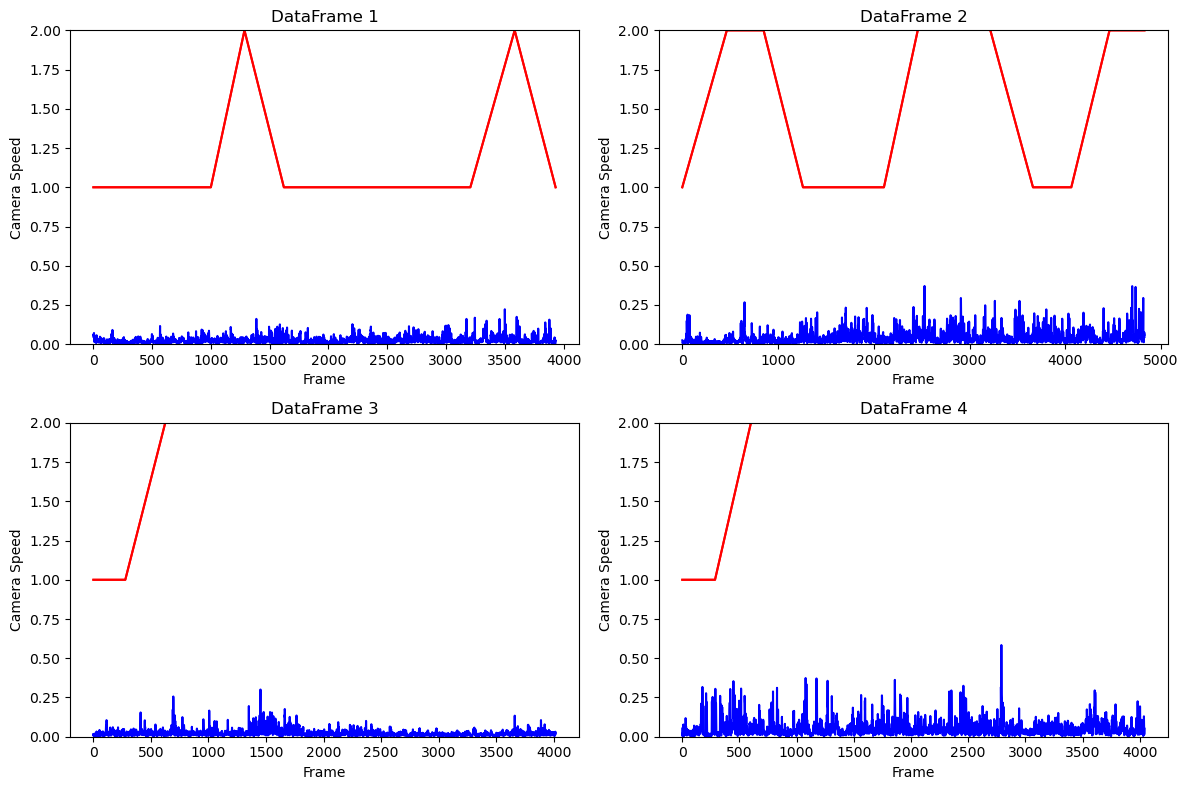

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

# Iterate over DataFrames and plot NearTouches
for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
    # df['c_roll'].plot(ax=axes[i])
    df_filtered = df.dropna(subset=['MS_rating'])
    df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    # df['le_yaw'].plot(ax=axes[i], color='orange')
    # df['re_pitch'].plot(ax=axes[i], color='blue')
    # df['c_speed1']= df['c_speed']/100
    df['Head_Speed'].plot(ax=axes[i], color='blue')
    df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Camera Speed')
    axes[i].set_ylim(0, 2)

plt.tight_layout()
plt.show()

#### Scene

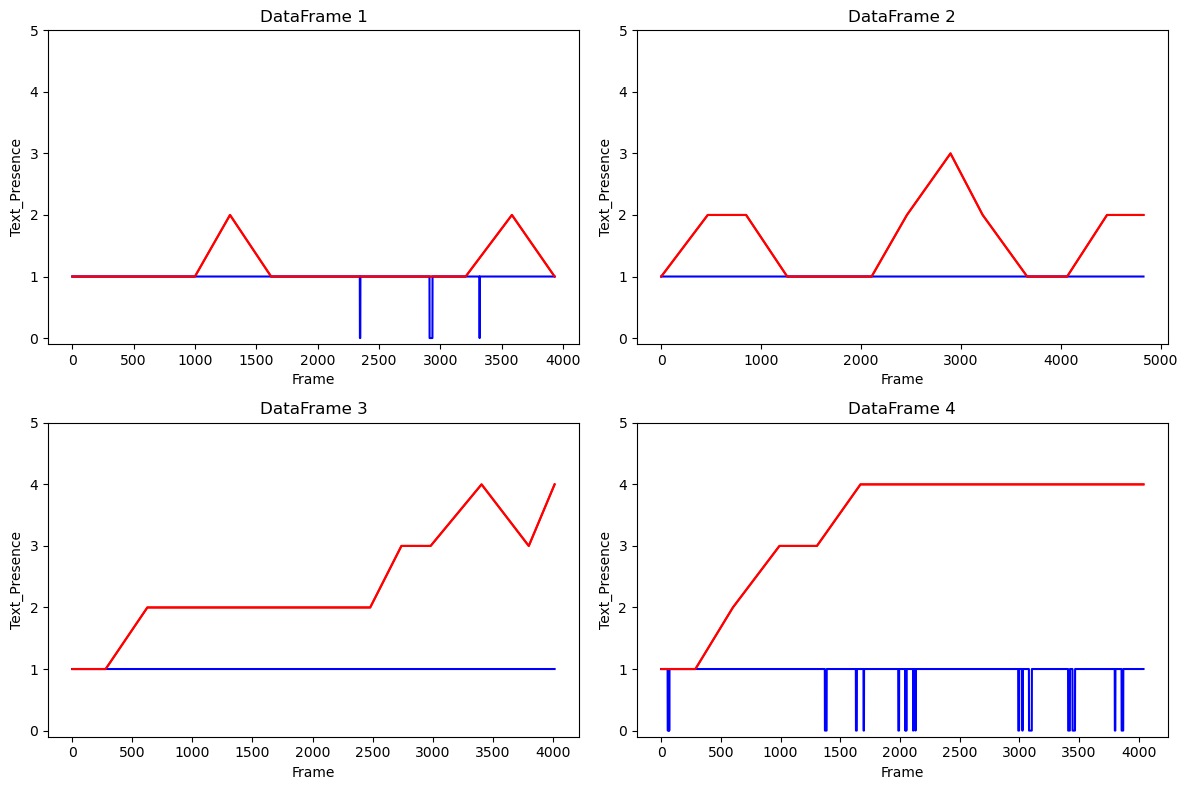

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

# Iterate over DataFrames and plot NearTouches
for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
    # df['c_roll'].plot(ax=axes[i])
    df_filtered = df.dropna(subset=['MS_rating'])
    df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    # df['le_yaw'].plot(ax=axes[i], color='orange')
    # df['re_pitch'].plot(ax=axes[i], color='blue')
    df['text_presence'].plot(ax=axes[i], color='blue')
    df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Text_Presence')
    axes[i].set_ylim(-0.1, 5)

plt.tight_layout()
plt.show()

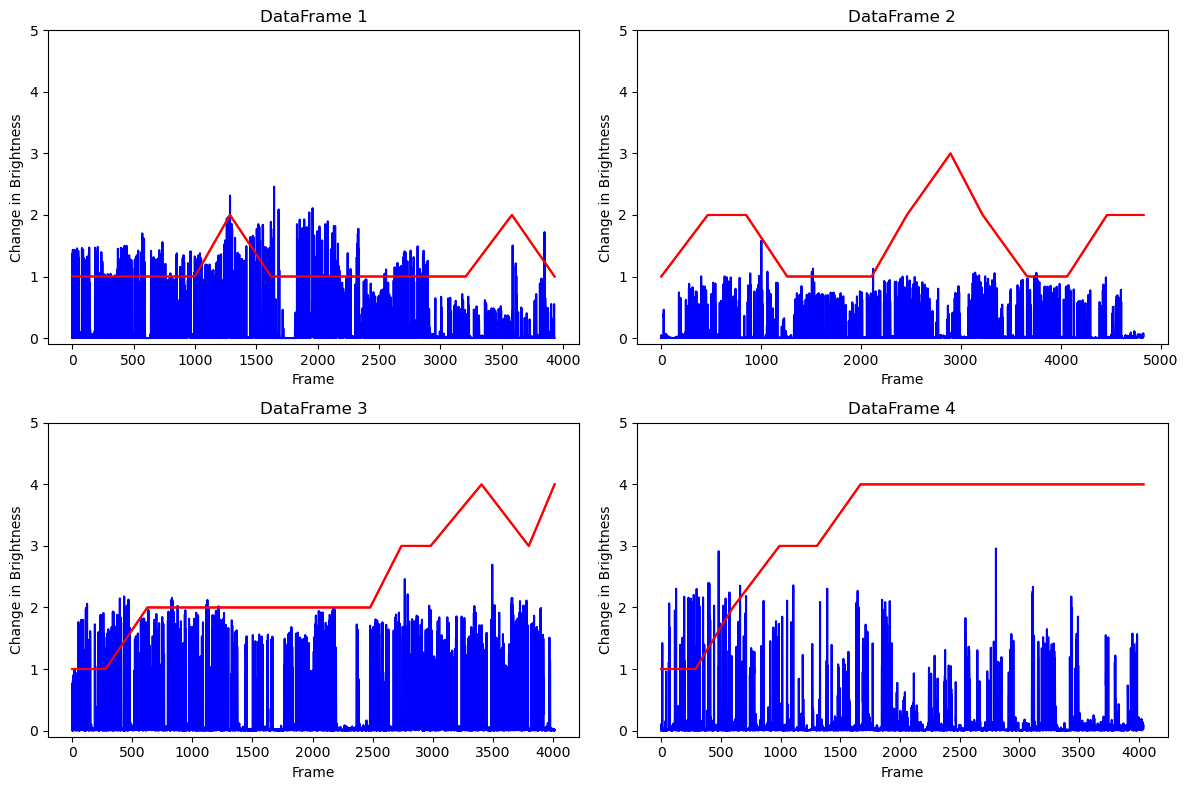

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

# Iterate over DataFrames and plot NearTouches
for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4]):
    # df['c_roll'].plot(ax=axes[i])
    df_filtered = df.dropna(subset=['MS_rating'])
    df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    # df['le_yaw'].plot(ax=axes[i], color='orange')
    # df['re_pitch'].plot(ax=axes[i], color='blue')
    df['change in brightness1']= df['change in brightness']/50
    df['change in brightness1'].plot(ax=axes[i], color='blue')
    df_filtered['MS_rating'].plot(ax=axes[i], color='red')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Change in Brightness')
    axes[i].set_ylim(-0.1, 5)

plt.tight_layout()
plt.show()

In [22]:
df_fin1.columns[50:80]

Index([], dtype='object')

In [34]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     df['PrevX_R'].plot(ax=axes[i])
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick X Right')

# plt.tight_layout()
# plt.show()

In [35]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     df['PrevY_R'].plot(ax=axes[i])
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Y Right')

# plt.tight_layout()
# plt.show()

In [36]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     df['Thumb_L'].plot(ax=axes[i])
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Left Magnitude')

# plt.tight_layout()
# plt.show()

In [37]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     df['Thumb_R'].plot(ax=axes[i])
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Right Magnitude')

# plt.tight_layout()
# plt.show()

In [137]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     df['Thumb_R'].plot(ax=axes[i])
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Right Magnitude')

# plt.tight_layout()
# plt.show()

In [12]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 11))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     df['Thumb_R_x'].plot(ax=axes[i])
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Right x direction change')

# plt.tight_layout()
# plt.show()

In [13]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 11))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     df['Thumb_R_y'].plot(ax=axes[i])
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Right y direction change')

# plt.tight_layout()
# plt.show()

In [14]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 11))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     df['Thumb_L_x'].plot(ax=axes[i])
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Left x direction change')

# plt.tight_layout()
# plt.show()

In [15]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 11))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     df['Thumb_L_y'].plot(ax=axes[i])
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Thumbstick Left y direction change')

# plt.tight_layout()
# plt.show()

In [24]:
sum(df2['NearTouches'])

nan

In [24]:
df_fin1.columns

Index(['frame', 'timestamp', 'head_dir', 'head_pos', 'head_vel', 'head_angvel',
       'left_eye_dir', 'left_eye_pos', 'left_eye_vel', 'left_eye_angvel',
       'right_eye_dir', 'right_eye_pos', 'right_eye_vel', 'right_eye_angvel',
       'left_eye', 'right_eye', 'confidence', 'is_valid',
       'ConnectedControllerTypes', 'Buttons', 'Touches', 'NearTouches',
       'IndexTrigger', 'HandTrigger', 'Thumbstick', 'object_name', 'bounds',
       'm_matrix', 'camera_name', 'p_matrix', 'v_matrix', 'video', 'MS_rating',
       'left_controller_dir', 'left_controller_pos', 'left_controller_vel',
       'left_controller_angvel', 'right_controller_dir',
       'right_controller_pos', 'right_controller_vel',
       'right_controller_angvel', 'IndTrig_L', 'IndTrig_R', 'HandTrig_L',
       'HandTrig_R', 'PrevX_L', 'PrevY_L', 'PrevX_R', 'PrevY_R', 'Thumb_L',
       'Thumb_R', 'Thumb_L_x', 'Thumb_R_x', 'Thumb_L_y', 'Thumb_R_y', 'x', 'y',
       'z', 'w', 'p1', 'p2', 'p3', 'LEye_Rot_Change', 'LEye_Pos

In [51]:
df_fin1["v_matrix"][-1006:-1005].to_list()

[[(1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   -1.0,
   0.0,
   5000.08251953125,
   3401.741455078125,
   -4999.38671875,
   1.0),
  (0.9926990270614624,
   0.05816265568137169,
   -0.1056680902838707,
   0.0,
   -0.05415154621005058,
   0.9977133870124817,
   0.04044242948293686,
   0.0,
   -0.10777870565652847,
   0.034425072371959686,
   -0.9935787320137024,
   0.0,
   4153.9306640625,
   5451.52099609375,
   -5294.29345703125,
   1.0)]]

In [54]:
df_fin1["v_matrix"][-1005:-1004].to_list()

[[(1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   -1.0,
   0.0,
   5000.0810546875,
   3401.742919921875,
   -4999.38525390625,
   1.0),
  (0.9918829202651978,
   0.05970919132232666,
   -0.11226347833871841,
   0.0,
   -0.05389842391014099,
   0.997079610824585,
   0.054103877395391464,
   0.0,
   -0.11516612023115158,
   0.04761388525366783,
   -0.9922044277191162,
   0.0,
   4114.17529296875,
   5522.03369140625,
   -5252.09033203125,
   1.0)]]

In [53]:
df_fin1["camera_name"][-1006:-1005].to_list()

[['UICamera', 'CenterEyeAnchor']]

In [45]:
df_fin5['camera_name'].value_counts().keys()[0]

['CenterEyeAnchor']

In [38]:
df_fin5

,frame,timestamp,head_dir,head_pos,head_vel,head_angvel,left_eye_dir,left_eye_pos,left_eye_vel,left_eye_angvel,...,p3,LEye_Rot_Change,LEye_Position_Change,REye_Rot_Change,REye_Position_Change,Head_Rot_Change,Head_Position_Change,Head_Velocity_Change,Head_AngVel_Change,Camera_rot
0,1750,1695618405889,"(-0.0576174221932888, 0.09596268832683563, 0.0...","(-0.21343141794204712, 0.03986649215221405, 0....","(-0.003757892409339547, 0.022930940613150597, ...","(0.28466057777404785, -0.00014114589430391788,...","(-0.0576174221932888, 0.09596268832683563, 0.0...","(-0.1800171285867691, 0.039839889854192734, 0....","(-0.003757892409339547, 0.022930940613150597, ...","(0.28466057777404785, -0.00014114589430391788,...",...,-0.104801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.141700
1,1760,1695618406026,"(-0.041450370103120804, 0.10007180273532867, 0...","(-0.21433621644973755, 0.04232766479253769, 0....","(-0.009238642640411854, 0.0161655955016613, -0...","(0.2002345621585846, 0.06549251079559326, -0.0...","(-0.041450370103120804, 0.10007180273532867, 0...","(-0.18097497522830963, 0.042090628296136856, 0...","(-0.009238642640411854, 0.0161655955016613, -0...","(0.2002345621585846, 0.06549251079559326, -0.0...",...,-0.081946,3.141593,0.000000,3.141593,0.000000,0.034558,0.002634,0.013271,0.109352,3.141594
2,1770,1695618406166,"(-0.033589962869882584, 0.10260840505361557, -...","(-0.21533513069152832, 0.04342716932296753, 0....","(-0.006411966402083635, 0.003910341300070286, ...","(0.07391433417797089, 0.01105477288365364, -0....","(-0.033589962869882584, 0.10260840505361557, -...","(-0.18200910091400146, 0.043066591024398804, 0...","(-0.006411966402083635, 0.003910341300070286, ...","(0.07391433417797089, 0.01105477288365364, -0....",...,-0.034514,3.141593,0.000000,3.141593,0.000000,0.017272,0.001488,0.012815,0.145499,3.141606
3,1780,1695618406304,"(-0.030887747183442116, 0.10491364449262619, -...","(-0.21643923223018646, 0.04351729527115822, 0....","(-0.013677635230123997, 0.0016962009249255061,...","(0.04485063999891281, 0.11485554277896881, -0....","(-0.030887747183442116, 0.10491364449262619, -...","(-0.1831468939781189, 0.04299502447247505, 0.2...","(-0.013677635230123997, 0.0016962009249255061,...","(0.04485063999891281, 0.11485554277896881, -0....",...,-0.094579,3.141593,0.000000,3.141593,0.000000,0.008808,0.001271,0.008230,0.123398,3.141672
4,1790,1695618406445,"(-0.031329672783613205, 0.11402732133865356, -...","(-0.2183721363544464, 0.04330553114414215, 0.2...","(-0.009170650504529476, -0.0047914511524140835...","(-0.06122029200196266, 0.07325053215026855, -0...","(-0.031329672783613205, 0.11402732133865356, -...","(-0.1852339655160904, 0.04191333428025246, 0.2...","(-0.009170650504529476, -0.0047914511524140835...","(-0.06122029200196266, 0.07325053215026855, -0...",...,-0.142047,3.141593,0.000000,3.141593,0.000000,0.031101,0.002145,0.008376,0.123431,3.142748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,21080,1695618713466,"(-0.06409987062215805, 0.38203755021095276, 0....","(-0.8194812536239624, 0.019575703889131546, 0....","(-0.009013375267386436, 0.01958371512591839, 0...","(0.1901639997959137, 0.05198698490858078, -0.1...","(-0.06409986317157745, 0.382037490606308, 0.01...","(-0.7953852415084839, 0.018658773973584175, -0...","(-0.009013375267386436, 0.01958371512591839, 0...","(0.1901639997959137, 0.05198698490858078, -0.1...",...,-0.187366,0.339802,0.003587,0.339252,0.003397,0.045926,0.004253,0.018486,0.145962,3.141721
1934,21090,1695618713604,"(-0.04906391352415085, 0.39555928111076355, 0....","(-0.8222606182098389, 0.02219109982252121, 0.0...","(-0.024326294660568237, 0.023247547447681427, ...","(0.19106832146644592, 0.24715758860111237, -0....","(-0.04906390607357025, 0.3955592215061188, 0.0...","(-0.7988739013671875, 0.021294787526130676, -0...","(-0.024326294660568237, 0.023247547447681427, ...","(0.19106832146644592, 0.24715758860111237, -0....",...,-0.205493,0.011572,0.003595,0.0

In [36]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     # df['c_roll'].plot(ax=axes[i])
#     # df_filtered = df.dropna(subset=['MS_rating'])
#     # df['MS_rating'].fillna(0, inplace=True)
#     df['le_pitch'].plot(ax=axes[i], color='orange')
#     df['re_pitch'].plot(ax=axes[i], color='blue')
#     df['h_pitch'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Left_Eye/Right_Eye/Head_Pitch')
#     # axes[i].set_ylim(-2, 2)

# plt.tight_layout()
# plt.show()

In [39]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     # df['c_roll'].plot(ax=axes[i])
#     # df_filtered = df.dropna(subset=['MS_rating'])
#     # df['MS_rating'].fillna(0, inplace=True)
#     df['le_roll'].plot(ax=axes[i], color='orange')
#     df['re_roll'].plot(ax=axes[i], color='blue')
#     df['h_roll'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Left_Eye/Right_Eye/Head_Roll')
#     # axes[i].set_ylim(-2, 2)

# plt.tight_layout()
# plt.show()

In [34]:
# fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# # Flatten the axes array
# axes = axes.flatten()

# # Iterate over DataFrames and plot NearTouches
# for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
#     # df['c_roll'].plot(ax=axes[i])
#     # df_filtered = df.dropna(subset=['MS_rating'])
#     # df['MS_rating'].fillna(0, inplace=True)
#     df['le_yaw'].plot(ax=axes[i], color='orange')
#     df['re_yaw'].plot(ax=axes[i], color='blue')
#     df['h_yaw'].plot(ax=axes[i], color='red')
#     axes[i].set_title(f'DataFrame {i+1}')
#     axes[i].set_xlabel('Frame')
#     axes[i].set_ylabel('Left_Eye/Right_Eye/Head_Pitch')
#     # axes[i].set_ylim(-2, 2)

# plt.tight_layout()
# plt.show()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

# Iterate over DataFrames and plot NearTouches
for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
    # df['c_roll'].plot(ax=axes[i])
    # df_filtered = df.dropna(subset=['MS_rating'])
    # df['MS_rating'].fillna(0, inplace=True)
    df[''].plot(ax=axes[i], color='orange')
    df[''].plot(ax=axes[i], color='blue')
    df[''].plot(ax=axes[i], color='red')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Left_Eye/Right_Eye/Head_Pitch')
    # axes[i].set_ylim(-2, 2)

plt.tight_layout()
plt.show()

In [8]:
df=df_fin5
non_nan_indexes = df['MS_rating'].dropna().index
# df['MS_rating']



In [9]:
non_nan_indexes

Int64Index([1, 287, 601, 991, 1305, 1670, 2048, 2312, 2620, 2943, 3279, 3602,
            4041],
           dtype='int64')

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

# Iterate over DataFrames and plot NearTouches
for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
    # df['c_roll'].plot(ax=axes[i])
    # df_filtered = df.dropna(subset=['MS_rating'])
    # df['MS_rating'].fillna(0, inplace=True)
    df['le_pitch'].plot(ax=axes[i], color='orange')
    df['re_pitch'].plot(ax=axes[i], color='blue')
    df['h_pitch'].plot(ax=axes[i], color='red')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Left_Eye/Right_Eye/Head_Pitch')
    # axes[i].set_ylim(-2, 2)

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np

def calculate_brightness(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Calculate average pixel intensity
    avg_intensity = np.mean(gray_image)
    return avg_intensity

def detect_lighting_changes(images):
    # Calculate average pixel intensity for each image
    # image = image.astype('uint8')
    brightness_values = [calculate_brightness(image.astype('uint8')) for image in images]
    # Calculate differences in brightness between consecutive images
    brightness_changes = [abs(brightness_values[i] - brightness_values[i+1]) for i in range(len(brightness_values)-1)]
    print(np.argmax(brightness_changes))
    # Define threshold for detecting major changes
    threshold = 20  # You may need to adjust this threshold based on your images
    # Check for major changes in brightness
    major_changes = any(change > threshold for change in brightness_changes)
    return major_changes

# Example usage
root_dir=
image_paths = vpaths # Paths to your image files
# print(image_paths)
images = [cv2.imread(image_path) for image_path in image_paths]

In [30]:
df_fin1.columns[20:]

Index(['Touches', 'NearTouches', 'IndexTrigger', 'HandTrigger', 'Thumbstick',
       'object_name', 'bounds', 'm_matrix', 'camera_name', 'p_matrix',
       'v_matrix', 'video', 'MS_rating', 'left_controller_dir',
       'left_controller_pos', 'left_controller_vel', 'left_controller_angvel',
       'right_controller_dir', 'right_controller_pos', 'right_controller_vel',
       'right_controller_angvel', 'IndTrig_L', 'IndTrig_R', 'HandTrig_L',
       'HandTrig_R', 'PrevX_L', 'PrevY_L', 'PrevX_R', 'PrevY_R', 'Thumb_L',
       'Thumb_R', 'Thumb_L_x', 'Thumb_R_x', 'Thumb_L_y', 'Thumb_R_y', 'le_x',
       'le_y', 'le_z', 'le_w', 'le_p1', 'le_p2', 'le_p3', 'le_roll',
       'le_pitch', 'le_yaw', 'LE_speed', 'LE_pos_change', 're_x', 're_y',
       're_z', 're_w', 're_p1', 're_p2', 're_p3', 're_roll', 're_pitch',
       're_yaw', 'RE_speed', 'RE_pos_change', 'h_x', 'h_y', 'h_z', 'h_w',
       'h_roll', 'h_pitch', 'h_yaw', 'h_p1', 'h_p2', 'h_p3', 'Head_Speed',
       'Head_pos_change', 'h_vp1', '

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))  # 2 rows, 2 columns

# Flatten the axes array
axes = axes.flatten()

# Iterate over DataFrames and plot NearTouches
for i, df in enumerate([df_fin1, df_fin2, df_fin3, df_fin4, df_fin5, df_fin6]):
    df_filtered=df
    # df['c_roll'].plot(ax=axes[i])
    # df_filtered = df.dropna(subset=['MS_rating'])
    # df['MS_rating'].fillna(0, inplace=True)
    df_filtered['change in brightness'].plot(ax=axes[i], color='orange')
    # df_filtered['RE_pos_change'].plot(ax=axes[i], color='blue')
    # df_filtered['h_x'].plot(ax=axes[i], color='red')
    axes[i].set_title(f'DataFrame {i+1}')
    axes[i].set_xlabel('Frame')
    axes[i].set_ylabel('Left_Eye/Right_Eye/Head_pos_change')
    # axes[i].set_ylim(-3, 3.5)

plt.tight_layout()
plt.show()

In [140]:
data1={"Earth_Gym": ["5_2_Earth_Gym", "10_2_Earth_Gym", "8_2_Earth_Gym", "3_1_Earth_Gym", "4_1_Earth_Gym", "7_1_Earth_Gym", "9_1_Earth_Gym"], "Wild_Quest": ["6_1_Wild_Quest", "5_1_Wild_Quest", "8_1_Wild_Quest", "10_1_Wild_Quest", "4_2_Wild_Quest", "7_2_Wild_Quest", "9_2_Wild_Quest"], "Roommate": ["145_1_Roommate", "142_1_Roommate", "138_2_Roommate", "144_2_Roommate", "139_2_Roommate", "136_2_Roommate", "137_2_Roommate", "140_2_Roommate", "141_1_Roommate", "143_2_Roommate"], "Waffle_Restaurant": ["140_1_Waffle_Restaurant", "135_1_Waffle_Restaurant", "144_1_Waffle_Restaurant", "143_1_Waffle_Restaurant", "136_1_Waffle_Restaurant", "145_2_Waffle_Restaurant", "142_2_Waffle_Restaurant", "137_1_Waffle_Restaurant", "139_1_Waffle_Restaurant", "138_1_Waffle_Restaurant", "141_2_Waffle_Restaurant"], "UFO_crash_site_venue": ["62_2_UFO_crash_site_venue", "57_1_UFO_crash_site_venue", "59_2_UFO_crash_site_venue", "60_2_UFO_crash_site_venue", "58_2_UFO_crash_site_venue", "55_2_UFO_crash_site_venue", "56_2_UFO_crash_site_venue", "54_1_UFO_crash_site_venue"], "The_aquarium": ["59_1_The_aquarium", "57_2_The_aquarium", "62_1_The_aquarium", "61_1_The_aquarium", "56_1_The_aquarium", "58_1_The_aquarium", "55_1_The_aquarium", "60_1_The_aquarium", "53_2_The_aquarium", "54_2_The_aquarium"], "Kowloon": ["64_1_Kowloon", "66_2_Kowloon", "67_2_Kowloon", "63_1_Kowloon", "65_1_Kowloon", "68_1_Kowloon", "71_2_Kowloon", "72_2_Kowloon", "70_2_Kowloon"], "Wake_the_Robot": ["64_2_Wake_the_Robot", "69_1_Wake_the_Robot", "70_1_Wake_the_Robot", "66_1_Wake_the_Robot", "68_2_Wake_the_Robot", "63_2_Wake_the_Robot", "65_2_Wake_the_Robot", "67_1_Wake_the_Robot", "71_1_Wake_the_Robot", "72_1_Wake_the_Robot"], "Scifi_Sandbox": ["43_1_Scifi_Sandbox", "45_1_Scifi_Sandbox", "49_1_Scifi_Sandbox", "47_1_Scifi_Sandbox", "46_1_Scifi_Sandbox", "51_1_Scifi_Sandbox", "50_1_Scifi_Sandbox", "52_2_Scifi_Sandbox", "48_1_Scifi_Sandbox", "44_2_Scifi_Sandbox"], "Citadel": ["40_2_Citadel", "42_2_Citadel", "36_1_Citadel", "34_1_Citadel", "31_1_Citadel", "32_1_Citadel", "41_2_Citadel", "37_1_Citadel", "38_2_Citadel", "35_2_Citadel"], "Super_Rumble": ["40_1_Super_Rumble", "36_2_Super_Rumble", "38_1_Super_Rumble", "34_2_Super_Rumble", "31_2_Super_Rumble", "41_1_Super_Rumble", "37_2_Super_Rumble", "33_2_Super_Rumble", "32_2_Super_Rumble", "35_1_Super_Rumble"], "Arena_Clash": ["45_2_Arena_Clash", "43_2_Arena_Clash", "47_2_Arena_Clash", "48_2_Arena_Clash", "52_1_Arena_Clash", "50_2_Arena_Clash", "46_2_Arena_Clash", "51_2_Arena_Clash", "44_1_Arena_Clash"], "Venues": ["78_2_Venues", "80_2_Venues", "76_2_Venues", "73_2_Venues", "75_2_Venues", "82_2_Venues", "77_2_Venues", "74_2_Venues", "79_2_Venues"], "Superhero_Arena": ["82_1_Superhero_Arena", "73_1_Superhero_Arena", "78_1_Superhero_Arena", "80_1_Superhero_Arena", "76_1_Superhero_Arena", "79_1_Superhero_Arena", "75_1_Superhero_Arena", "77_1_Superhero_Arena", "81_1_Superhero_Arena", "74_1_Superhero_Arena"], "Army_Men": ["28_2_Army_Men", "30_2_Army_Men", "25_1_Army_Men", "23_1_Army_Men", "26_1_Army_Men", "27_1_Army_Men", "24_1_Army_Men", "22_1_Army_Men", "21_1_Army_Men"], "Bobber_Bay_Fishing": ["25_2_Bobber_Bay_Fishing", "30_1_Bobber_Bay_Fishing", "23_2_Bobber_Bay_Fishing", "27_2_Bobber_Bay_Fishing", "29_2_Bobber_Bay_Fishing", "26_2_Bobber_Bay_Fishing", "24_2_Bobber_Bay_Fishing", "21_2_Bobber_Bay_Fishing", "22_2_Bobber_Bay_Fishing"], "Mars_Miners": ["16_1_Mars_Miners", "18_1_Mars_Miners", "17_1_Mars_Miners", "15_1_Mars_Miners", "11_2_Mars_Miners", "12_2_Mars_Miners", "19_1_Mars_Miners"], "American_Idol": ["13_2_American_Idol", "20_2_American_Idol", "15_2_American_Idol", "17_2_American_Idol", "16_2_American_Idol", "19_2_American_Idol", "12_1_American_Idol", "11_1_American_Idol"], "Metdonalds": ["86_1_Metdonalds", "88_1_Metdonalds", "84_2_Metdonalds", "85_1_Metdonalds", "83_2_Metdonalds", "92_1_Metdonalds", "89_1_Metdonalds", "91_1_Metdonalds", "90_2_Metdonalds"], "3D_Play_House": ["88_2_3D_Play_House", "86_2_3D_Play_House", "84_1_3D_Play_House", "92_2_3D_Play_House", "89_2_3D_Play_House", "91_2_3D_Play_House", "90_1_3D_Play_House", "85_2_3D_Play_House"], "Kawaii_Daycare": ["132_2_Kawaii_Daycare", "133_2_Kawaii_Daycare", "134_2_Kawaii_Daycare", "127_2_Kawaii_Daycare", "128_2_Kawaii_Daycare", "125_2_Kawaii_Daycare", "130_2_Kawaii_Daycare", "126_2_Kawaii_Daycare", "129_2_Kawaii_Daycare"], "Giant_Paddle_Golf": ["134_1_Giant_Paddle_Golf", "132_1_Giant_Paddle_Golf", "133_1_Giant_Paddle_Golf", "125_1_Giant_Paddle_Golf", "130_1_Giant_Paddle_Golf", "127_1_Giant_Paddle_Golf", "126_1_Giant_Paddle_Golf", "131_1_Giant_Paddle_Golf", "128_1_Giant_Paddle_Golf", "129_1_Giant_Paddle_Golf"], "City_Parkour": ["146_1_City_Parkour", "150_2_City_Parkour", "148_1_City_Parkour", "153_2_City_Parkour", "147_2_City_Parkour", "151_2_City_Parkour", "149_1_City_Parkour", "155_1_City_Parkour", "154_2_City_Parkour", "152_2_City_Parkour"], "Slash_RPG": ["104_2_Slash_RPG", "107_2_Slash_RPG", "111_2_Slash_RPG", "106_2_Slash_RPG", "113_2_Slash_RPG", "109_2_Slash_RPG", "108_1_Slash_RPG", "112_2_Slash_RPG", "110_2_Slash_RPG", "105_2_Slash_RPG", "114_2_Slash_RPG"], "Pirate_Life": ["109_1_Pirate_Life", "106_1_Pirate_Life", "114_1_Pirate_Life", "107_1_Pirate_Life", "111_1_Pirate_Life", "110_1_Pirate_Life", "104_1_Pirate_Life", "113_1_Pirate_Life", "105_1_Pirate_Life", "108_2_Pirate_Life", "112_1_Pirate_Life"], "Zombie": ["115_1_Zombie", "118_2_Zombie", "119_1_Zombie", "124_1_Zombie", "121_2_Zombie", "116_2_Zombie", "117_1_Zombie", "123_1_Zombie", "120_1_Zombie", "122_1_Zombie"], "VR_Classroom": ["103_2_VR_Classroom", "101_2_VR_Classroom", "102_2_VR_Classroom", "100_2_VR_Classroom", "98_2_VR_Classroom", "96_2_VR_Classroom", "95_2_VR_Classroom", "94_1_VR_Classroom", "99_2_VR_Classroom", "93_2_VR_Classroom", "97_2_VR_Classroom"], "Horizon_Boxing": ["116_1_Horizon_Boxing", "115_2_Horizon_Boxing", "118_1_Horizon_Boxing", "121_1_Horizon_Boxing", "124_2_Horizon_Boxing", "120_2_Horizon_Boxing", "119_2_Horizon_Boxing", "122_2_Horizon_Boxing", "117_2_Horizon_Boxing", "123_2_Horizon_Boxing"], "Titanic_Simulation": ["102_1_Titanic_Simulation", "101_1_Titanic_Simulation", "93_1_Titanic_Simulation", "94_2_Titanic_Simulation", "97_1_Titanic_Simulation", "100_1_Titanic_Simulation", "98_1_Titanic_Simulation", "96_1_Titanic_Simulation", "95_1_Titanic_Simulation", "99_1_Titanic_Simulation"], "Out_Of_Control": ["173_2_Out_Of_Control", "174_2_Out_Of_Control", "172_2_Out_Of_Control", "171_2_Out_Of_Control", "169_2_Out_Of_Control", "167_2_Out_Of_Control", "170_2_Out_Of_Control", "166_2_Out_Of_Control", "168_2_Out_Of_Control"], "Geometry_Gunners": ["162_2_Geometry_Gunners", "163_2_Geometry_Gunners", "164_2_Geometry_Gunners", "165_2_Geometry_Gunners", "158_1_Geometry_Gunners", "160_1_Geometry_Gunners", "157_2_Geometry_Gunners", "156_2_Geometry_Gunners", "159_1_Geometry_Gunners", "161_2_Geometry_Gunners"], "Barnyard": ["165_1_Barnyard", "164_1_Barnyard", "163_1_Barnyard", "159_2_Barnyard", "162_1_Barnyard", "158_2_Barnyard", "157_1_Barnyard", "160_2_Barnyard", "161_1_Barnyard", "156_1_Barnyard"], "Canyon_Runners": ["174_1_Canyon_Runners", "173_1_Canyon_Runners", "169_1_Canyon_Runners", "166_1_Canyon_Runners", "170_1_Canyon_Runners", "167_1_Canyon_Runners", "171_1_Canyon_Runners", "168_1_Canyon_Runners", "172_1_Canyon_Runners"], "Creature_Feature": ["150_1_Creature_Feature", "146_2_Creature_Feature", "152_1_Creature_Feature", "153_1_Creature_Feature", "154_1_Creature_Feature", "155_2_Creature_Feature", "151_1_Creature_Feature", "147_1_Creature_Feature"]}

In [143]:
data1.keys()

dict_keys(['Earth_Gym', 'Wild_Quest', 'Roommate', 'Waffle_Restaurant', 'UFO_crash_site_venue', 'The_aquarium', 'Kowloon', 'Wake_the_Robot', 'Scifi_Sandbox', 'Citadel', 'Super_Rumble', 'Arena_Clash', 'Venues', 'Superhero_Arena', 'Army_Men', 'Bobber_Bay_Fishing', 'Mars_Miners', 'American_Idol', 'Metdonalds', '3D_Play_House', 'Kawaii_Daycare', 'Giant_Paddle_Golf', 'City_Parkour', 'Slash_RPG', 'Pirate_Life', 'Zombie', 'VR_Classroom', 'Horizon_Boxing', 'Titanic_Simulation', 'Out_Of_Control', 'Geometry_Gunners', 'Barnyard', 'Canyon_Runners', 'Creature_Feature'])

In [144]:
len(data1.keys())

34

In [146]:
count=0
for i in data1.keys():
    count+=len(data1[i])
    print(i, len(data1[i]))

Earth_Gym 7
Wild_Quest 7
Roommate 10
Waffle_Restaurant 11
UFO_crash_site_venue 8
The_aquarium 10
Kowloon 9
Wake_the_Robot 10
Scifi_Sandbox 10
Citadel 10
Super_Rumble 10
Arena_Clash 9
Venues 9
Superhero_Arena 10
Army_Men 9
Bobber_Bay_Fishing 9
Mars_Miners 7
American_Idol 8
Metdonalds 9
3D_Play_House 8
Kawaii_Daycare 9
Giant_Paddle_Golf 10
City_Parkour 10
Slash_RPG 11
Pirate_Life 11
Zombie 10
VR_Classroom 11
Horizon_Boxing 10
Titanic_Simulation 10
Out_Of_Control 9
Geometry_Gunners 10
Barnyard 10
Canyon_Runners 9
Creature_Feature 8


In [147]:
count


318

In [2]:
import pandas as pd

In [8]:
ml=pd.read_csv('main_log.csv')

In [11]:
ml2=ml[(ml['pose']==1) & (ml['gaze']==1) & (ml['control']==1) & (ml['scene_obj']==1) & (ml['video']==1) & (ml['MS_rating']==1)]

In [15]:
list1=ml2['name'].to_list()

In [18]:
games={}
for i in list1:
    gamename="_".join(i.split("_")[2:])
    if gamename not in games.keys():
        games[gamename]=[]
    games[gamename].append(i)

In [20]:
for i in games.keys():
    print(i, len(games[i]))

Earth_Gym 5
Wild_Quest 6
Roommate 10
Waffle_Restaurant 11
Superhero_Arena 6
Army_Men 7
Bobber_Bay_Fishing 7
Citadel 5
Mars_Miners 7
American_Idol 6
Kawaii_Daycare 9
Giant_Paddle_Golf 9
City_Parkour 10
Wake_the_Robot 8
The_aquarium 7
UFO_crash_site_venue 5
Kowloon 8
Arena_Clash 6
Scifi_Sandbox 6
Super_Rumble 5
Slash_RPG 11
Pirate_Life 11
Zombie 10
Horizon_Boxing 10
VR_Classroom 6
Venues 5
Metdonalds 6
3D_Play_House 5
Out_Of_Control 9
Geometry_Gunners 10
Barnyard 10
Canyon_Runners 9
Titanic_Simulation 6
Creature_Feature 8


In [22]:
import json
with open("games_used1", "w") as json_file:
    json.dump(games, json_file)

In [5]:
cd ..

/home/dinithi/vr-motion-sickness-modelling


In [6]:
cd DataExtractionScripts/log_csvs/

/home/dinithi/vr-motion-sickness-modelling/DataExtractionScripts/log_csvs


In [23]:
dta=load_json('games_used1.json')

NameError: name 'load_json' is not defined

In [11]:
# ls /data/VR_NET/folders

In [1]:
games1={'Earth_Gym': ['5_2_Earth_Gym',
  '10_2_Earth_Gym'],
 'Wild_Quest': ['6_1_Wild_Quest',
  '5_1_Wild_Quest']}

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import csv
import math
import json
import ast
import cv2

from clean import * 
from aggregation import *


game_abbs={'Earth_Gym': 1,
 'Wild_Quest': 2,
 'Roommate': 3,
 'Waffle_Restaurant': 4,
 'Superhero_Arena': 5,
 'Army_Men': 6,
 'Bobber_Bay_Fishing': 7,
 'Citadel': 8,
 'Mars_Miners': 9,
 'American_Idol': 10,
 'Kawaii_Daycare': 11,
 'Giant_Paddle_Golf': 12,
 'City_Parkour': 13,
 'Wake_the_Robot': 14,
 'The_aquarium': 15,
 'UFO_crash_site_venue': 16,
 'Kowloon': 17,
 'Arena_Clash': 18,
 'Scifi_Sandbox': 19,
 'Super_Rumble': 20,
 'Slash_RPG': 21,
 'Pirate_Life': 22,
 'Zombie': 23,
 'Horizon_Boxing': 24,
 'VR_Classroom': 25,
 'Venues': 26,
 'Metdonalds': 27,
 '3D_Play_House': 28,
 'Out_Of_Control': 29,
 'Geometry_Gunners': 30,
 'Barnyard': 31,
 'Canyon_Runners': 32,
 'Titanic_Simulation': 33,
 'Creature_Feature': 34}

cleaned_dfs = []

def panel(df, user_id, game_id,order):
    df.reset_index(drop=False, inplace=True)
    df.rename(columns={'index': 'time'}, inplace=True)
    df['user_id'] = user_id
    df['game_id'] = game_id  
    df['order'] = order 
    return df

with open('/home/dinithi/vr-motion-sickness-modelling/DataExtractionScripts/log_csvs/games_used1.json', 'r') as f:
    games = json.load(f)

root_dir='/data/VR_NET/folders'

for game in games1:
    for sess in games1[game]:
        sess_path=os.path.join(root_dir, game, sess)
        user_id=int(sess.split('_')[0])
        game_id=game_abbs[game]
        order=int(sess.split('_')[1])
        # print(sess_path)
        df_clean=clean(sess_path)
        df_agg=aggregate(df_clean)
        df_fin=panel(df_agg, user_id, game_id,order)
        cleaned_dfs.append(df_fin)

panel_df = pd.concat(cleaned_dfs, ignore_index=True)

panel_df.to_csv('panel_data.csv',  index=False)


In [7]:
panel_df

,time,Thumb_L_sum,Thumb_R_sum,LE_speed_mean,LE_speed_median,LE_pos_change_sum,LE_pos_change_mean,LE_pos_change_median,Head_Speed_mean,Head_Speed_median,...,IndTrig_R,HandTrig_L,HandTrig_R,Thumb_L_x,Thumb_R_x,Thumb_L_y,Thumb_R_y,user_id,game_id,order
0,0,0.000000,3.594337,0.127828,0.090655,2.316057,0.020865,0.012802,0.172464,0.125845,...,0,32,0,0,3,0,3,5,1,2
1,1,33.093972,62.157799,0.063716,0.036334,3.967072,0.013448,0.005704,0.063247,0.036310,...,12,48,15,64,43,66,40,5,1,2
2,2,46.027865,90.608110,0.068397,0.042165,3.758526,0.009813,0.006048,0.067828,0.040388,...,4,62,37,100,63,93,70,5,1,2
3,3,18.430878,5.229467,0.068757,0.038978,3.775398,0.010068,0.005633,0.069725,0.037508,...,272,71,127,14,7,11,5,5,1,2
4,4,26.719036,1.597837,0.150314,0.117524,8.961758,0.022349,0.017352,0.153218,0.125837,...,203,27,157,22,5,21,5,5,1,2
5,5,47.349634,26.812417,0.100103,0.063776,5.959936,0.014536,0.009331,0.100336,0.062262,...,139,252,159,80,21,88,17,5,1,2
6,6,30.165039,4.056569,0.110321,0.078401,6.178497,0.015842,0.011130,0.110816,0.077161,...,216,117,120,24,3,24,3,5,1,2
7,7,7.823692,0.000000,0.141623,0.086077,8.269608,0.019927,0.011946,0.142115,0.087659,...,240,157,306,14,0,17,0,5,1,2
8,8,52.179832,35.365552,0.044190,0.027088,2.568030,0.006279,0.003829,0.044771,0.027455,...,313,128,320,53,25,65,23,5,1,2
9,9,30.910127,4.448247,0.083647,0.055181,4.956641,0.011858,0.007789,0.084510,0.054315,...,276,34,100,27,4,29,5,5,1,2


In [9]:
# df_fin

In [18]:
# len(df_agg.columns)

In [19]:
def panel(df, user_id, game_id):
    df.reset_index(drop=False, inplace=True)
    df.rename(columns={'index': 'time'}, inplace=True)
    df['user_id'] = user_id
    df['game_id'] = game_id   
    return df

In [25]:
gamesabb={}
count=1
for game in games.keys():
    gamesabb[game]=count
    count+=1

In [5]:
df_agg2=df_agg

In [6]:
df_agg2.reset_index(drop=False, inplace=True)

In [15]:
# df_agg2

In [21]:
df_agg3=df_agg

In [23]:
# panel(df_agg3, 2, 'A')

In [10]:
# gamesabb